In [ ]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names=dataset.class_names

In [5]:
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
len(dataset)

68

In [7]:
68*32

2176

In [8]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 0 0 2 1 1 0 0 1 1 1 2 0 0 1 1 1 0 1 1 0 0 1 2 1 0 0 0 0 1 0 0]


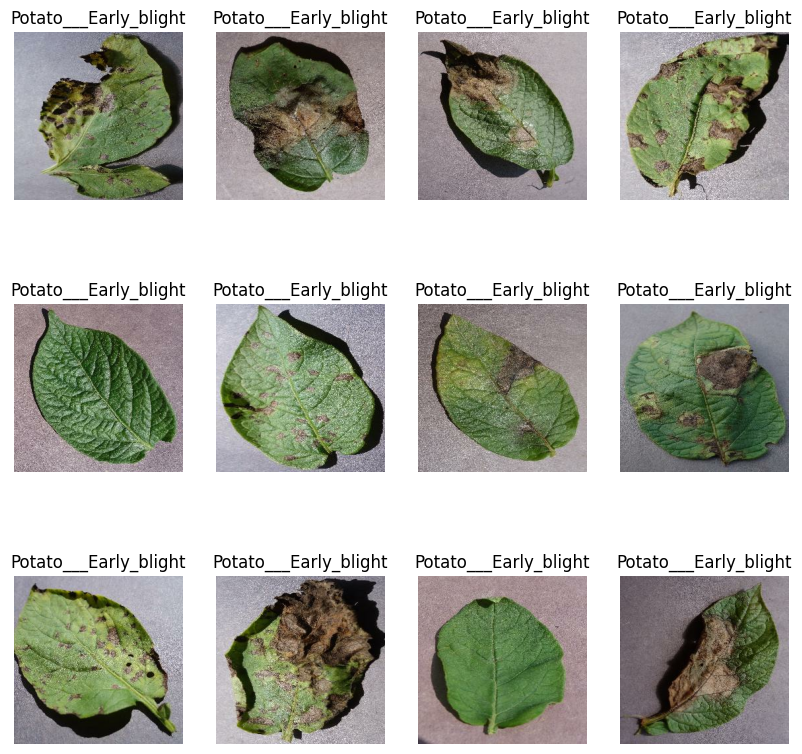

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.axis('off')
        plt.title(class_names[label_batch[0]])


In [10]:
len(dataset)

68

80% train
20% ->10% validation 10% test

In [11]:
train_size=0.8
len(dataset)*train_size

54.400000000000006

In [12]:
train_ds=dataset.take(54)
len(train_ds)

54

In [13]:
test_ds=dataset.skip(54)
len(test_ds)

14

In [14]:
val_size=0.1
val_ds=test_ds.take(6)
len(val_ds)

6

In [15]:
def get_dataset_partitions(ds,train_split=0.8,test_split=0.1,val_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
    train_size=int(ds_size*train_split)
    val_size=int(ds_size*val_split)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds,test_ds,val_ds

In [16]:
train_ds,test_ds,val_ds=get_dataset_partitions(dataset)


In [17]:
len(test_ds)

8

In [18]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [19]:
resize_and_rescale=tf.keras.Sequential([

    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [20]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [21]:
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes=3
model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3), activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax'),
])
model.build(input_shape=input_shape)

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [23]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
)

In [ ]:
history=model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds,
)

Epoch 1/40
54/54 [==============================] - 279s 5s/step - loss: 0.5282 - accuracy: 0.7645 - val_loss: 0.4119 - val_accuracy: 0.8438
Epoch 2/40
54/54 [==============================] - 158s 3s/step - loss: 0.3547 - accuracy: 0.8495 - val_loss: 0.1540 - val_accuracy: 0.9479
Epoch 3/40
54/54 [==============================] - 149s 3s/step - loss: 0.2669 - accuracy: 0.8964 - val_loss: 0.1225 - val_accuracy: 0.9531
Epoch 4/40
54/54 [==============================] - 176s 3s/step - loss: 0.2374 - accuracy: 0.9120 - val_loss: 0.3005 - val_accuracy: 0.8750
Epoch 5/40
54/54 [==============================] - 166s 3s/step - loss: 0.2023 - accuracy: 0.9167 - val_loss: 0.1836 - val_accuracy: 0.9323
Epoch 6/40
39/54 [====================>.........] - ETA: 2:56 - loss: 0.1273 - accuracy: 0.9583

In [77]:
scores=model.evaluate(test_ds)


8/8 [==============================] - 41s 555ms/step - loss: 0.2045 - accuracy: 0.9297


In [79]:
scores

[0.20449098944664001, 0.9296875]

In [80]:
history

In [81]:
history.params

{'verbose': 1, 'epochs': 21, 'steps': 54}

In [83]:
history.history.keys()


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [84]:
history.history['accuracy']

[0.7777777910232544,
 0.8339120149612427,
 0.8564814925193787,
 0.8877314925193787,
 0.9114583134651184,
 0.9207175970077515,
 0.9293981194496155,
 0.9375,
 0.9305555820465088,
 0.9427083134651184,
 0.9560185074806213,
 0.9149305820465088,
 0.953125,
 0.9710648059844971,
 0.9722222089767456,
 0.9641203880310059,
 0.9832175970077515,
 0.9837962985038757,
 0.9930555820465088,
 0.9826388955116272,
 0.9895833134651184]

In [109]:

acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']



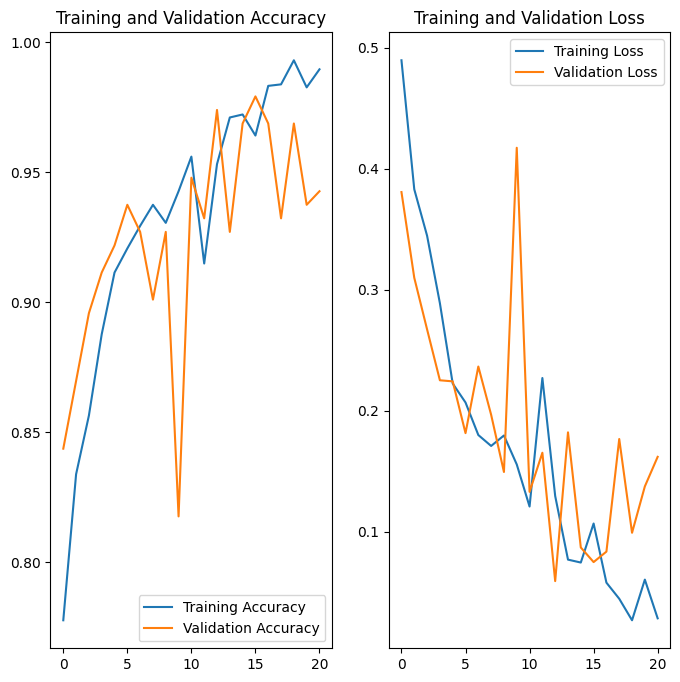

In [110]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='Training Loss')
plt.plot(range(EPOCHS),val_loss,label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

First image to predict
Actual Label: Potato___Late_blight
1/1 [==============================] - 1s 684ms/step
Potato___Late_blight


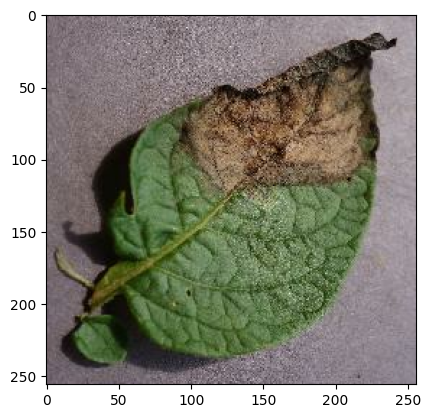

In [147]:
import numpy as np
for image_batch,labels_batch in test_ds.take(1):
    first_image=image_batch[0].numpy().astype('uint8')
    first_label=labels_batch[0].numpy()
    print("First image to predict")
    plt.imshow(first_image)
    print("Actual Label:",class_names[first_label])
    batch_prediction=model.predict(image_batch)
    print(class_names[np.argmax(batch_prediction[0])])

In [142]:
def predict(model,img):
    img_array=tf.keras.preprocessing.img_to_array(im)

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [150]:
model_version=1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets
